# ONNX export with --end2end flag can export a onnx with nms
# Batch size is 3

In [1]:
!python3 deploy/ONNX/export_onnx.py  --weights weights/yolov6s.pt --end2end --device 0 --batch-size 3

Namespace(batch_size=3, conf_thres=0.25, device='0', end2end=True, half=False, img_size=[640, 640], inplace=False, iou_thres=0.45, topk_all=100, weights='weights/yolov6s.pt')
Loading checkpoint from weights/yolov6s.pt

Fusing model...
/home/ubuntu/miniconda3/envs/torch/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

Starting to export ONNX...
/home/ubuntu/work/yolo/YOLOv6/yolov6/models/effidehead.py:76: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != y.shape[2:4]:
/home/ubuntu/miniconda3/envs

In [2]:
import cv2
import time
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

In [3]:
cuda = False
w = "weights/yolov6s.onnx"
pics = Path('data/images')

In [4]:
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
session = ort.InferenceSession(w, providers=providers)

In [5]:
from yolov6.data.data_augment import letterbox

In [6]:
names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

In [7]:
batch = []
images = []
for i in pics.iterdir():
    image = cv2.imread(str(i))
    image,ratio,dwdh = letterbox(image,auto=False)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    images.append(image.copy())
    image = image.transpose((2, 0, 1))
    image = np.expand_dims(image,0)
    image = np.ascontiguousarray(image)
    batch.append(image)

In [8]:
im = np.concatenate(batch,axis=0)
im = im.astype(np.float32)
im/=255
im.shape

(3, 3, 640, 640)

In [9]:
outname = [i.name for i in session.get_outputs()]
outname

['outputs']

In [10]:
inname = [i.name for i in session.get_inputs()]
inname

['image_arrays']

In [11]:
outputs = session.run(outname, {inname[0]:im})[0]

In [12]:
outputs

array([[0.00000000e+00, 4.93651276e+01, 2.74889740e+02, 1.88910965e+02,
        4.12123077e+02, 3.20000000e+01, 9.62332904e-01],
       [0.00000000e+00, 4.23720337e+02, 1.06865204e+02, 6.30935791e+02,
        5.52392700e+02, 0.00000000e+00, 9.45102692e-01],
       [0.00000000e+00, 3.42312622e+01, 1.01240097e+02, 4.59978333e+02,
        5.53476196e+02, 0.00000000e+00, 9.42423403e-01],
       [1.00000000e+00, 2.02236389e+02, 3.28533783e+01, 5.26948181e+02,
        5.05931580e+02, 1.70000000e+01, 9.37667012e-01],
       [1.00000000e+00, 1.10992264e+02, 3.17085419e+02, 3.77475220e+02,
        5.79645508e+02, 1.60000000e+01, 9.32848334e-01],
       [2.00000000e+00, 3.58749390e-01, 6.13036499e+01, 3.97775452e+02,
        5.79651794e+02, 0.00000000e+00, 9.42549348e-01],
       [2.00000000e+00, 2.58799927e+02, 1.35689194e+02, 6.32847046e+02,
        5.81431702e+02, 0.00000000e+00, 9.40890729e-01],
       [2.00000000e+00, 1.95732422e+02, 2.55366760e+02, 2.53729584e+02,
        4.69948853e+02, 2

In [13]:
outputs.shape

(8, 7)

In [14]:
for i,(batch,x0,y0,x1,y1,clas,score) in enumerate(outputs):
    image_copy = images[int(batch)]
    name = names[int(clas)]
    color = colors[name]
    cv2.rectangle(image_copy,[int(x0.round()),int(y0.round())],[int(x1.round()),int(y1.round())],color,2)
    cv2.putText(image_copy,name,(int(x0.round()), int(y0.round())-2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)

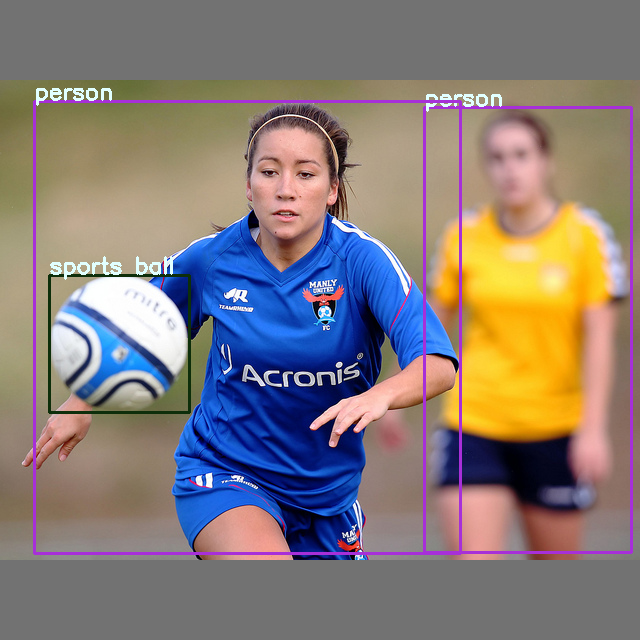

In [15]:
Image.fromarray(images[0])

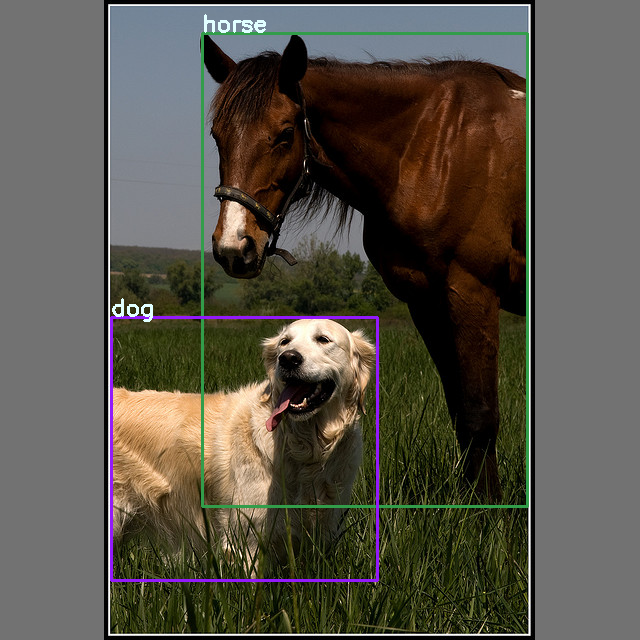

In [16]:
Image.fromarray(images[1])

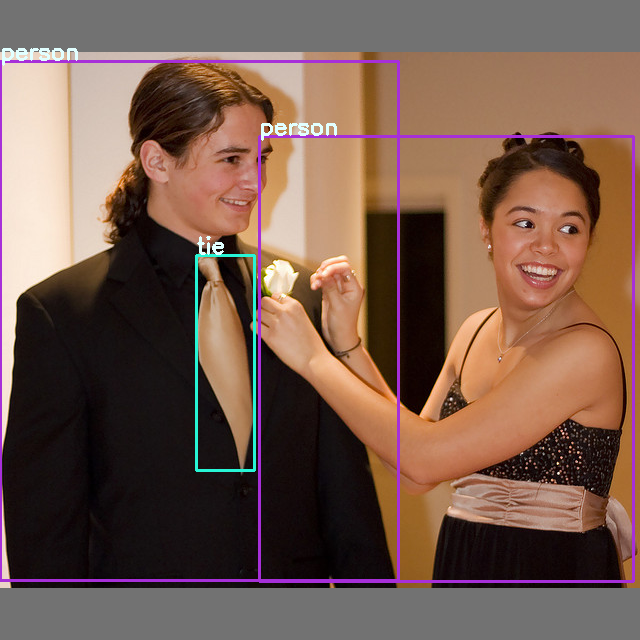

In [17]:
Image.fromarray(images[2])